In [1]:
import pandas as pd

df = pd.read_csv("Stress_Dataset.csv")

df["Stress_Label"] = (
    df["Which type of stress do you primarily experience?"]
      .str.extract("(Eustress|Distress|No Stress)", expand=False)
      .str.strip()
)

df = df.drop(columns=["Which type of stress do you primarily experience?"])

X = df.drop(columns=["Stress_Label"])
y = df["Stress_Label"]

print(X.shape, y.value_counts())


(843, 25) Stress_Label
Eustress     768
No Stress     43
Distress      32
Name: count, dtype: int64


**LAB 5. DBSCAN**

eps=0.3, min_samples=5, clusters=0, noise=843, sil=None


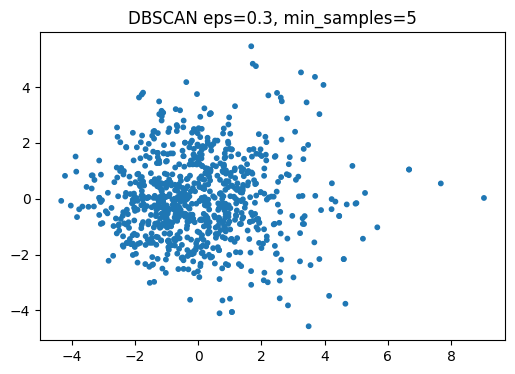

eps=0.5, min_samples=5, clusters=0, noise=843, sil=None


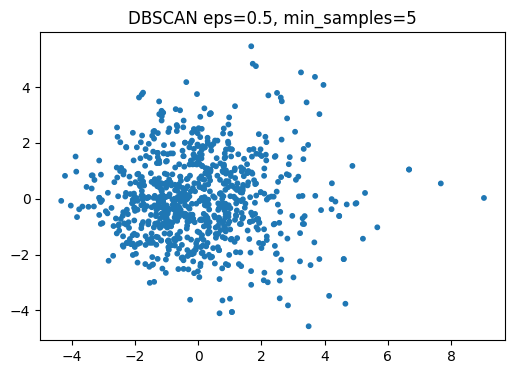

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

X_scaled = StandardScaler().fit_transform(X)

# DBSCAN эксперименты
params = [{'eps': 0.3, 'min_samples': 5}, {'eps': 0.5, 'min_samples': 5}]
for p in params:
    db = DBSCAN(eps=p['eps'], min_samples=p['min_samples'])
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    sil = silhouette_score(X_scaled, labels) if n_clusters > 1 else None
    print(f"eps={p['eps']}, min_samples={p['min_samples']}, clusters={n_clusters}, noise={n_noise}, sil={sil}")

    pca = PCA(n_components=2)
    X_vis = pca.fit_transform(X_scaled)
    plt.figure(figsize=(6,4))
    plt.scatter(X_vis[:,0], X_vis[:,1], c=labels, cmap='tab10', s=10)
    plt.title(f"DBSCAN eps={p['eps']}, min_samples={p['min_samples']}")
    plt.show()


**LAB 6. SVM ACCURACY XGBOOST**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np

le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_enc, stratify=y_enc, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train_enc)
y_pred_svm_enc = svm_model.predict(X_test)

y_test_str = le.inverse_transform(y_test_enc)
y_pred_svm_str = le.inverse_transform(y_pred_svm_enc)

print("SVM Accuracy:", accuracy_score(y_test_enc, y_pred_svm_enc))
print(classification_report(y_test_str, y_pred_svm_str))
print("Confusion matrix (SVM):\n", confusion_matrix(y_test_str, y_pred_svm_str))

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train_enc)

y_pred_xgb_enc = np.argmax(xgb_model.predict_proba(X_test), axis=1)

y_pred_xgb_str = le.inverse_transform(y_pred_xgb_enc)

print("XGBoost Accuracy:", accuracy_score(y_test_enc, y_pred_xgb_enc))
print(classification_report(y_test_str, y_pred_xgb_str))
print("Confusion matrix (XGBoost):\n", confusion_matrix(y_test_str, y_pred_xgb_str))


Label mapping: {'Distress': np.int64(0), 'Eustress': np.int64(1), 'No Stress': np.int64(2)}
SVM Accuracy: 0.9704142011834319
              precision    recall  f1-score   support

    Distress       1.00      0.67      0.80         6
    Eustress       0.97      1.00      0.98       154
   No Stress       1.00      0.67      0.80         9

    accuracy                           0.97       169
   macro avg       0.99      0.78      0.86       169
weighted avg       0.97      0.97      0.97       169

Confusion matrix (SVM):
 [[  4   2   0]
 [  0 154   0]
 [  0   3   6]]
XGBoost Accuracy: 0.9585798816568047
              precision    recall  f1-score   support

    Distress       1.00      0.83      0.91         6
    Eustress       0.96      1.00      0.98       154
   No Stress       1.00      0.33      0.50         9

    accuracy                           0.96       169
   macro avg       0.99      0.72      0.80       169
weighted avg       0.96      0.96      0.95       169

Confu

**LAB 7. PCA AND t-SNE**

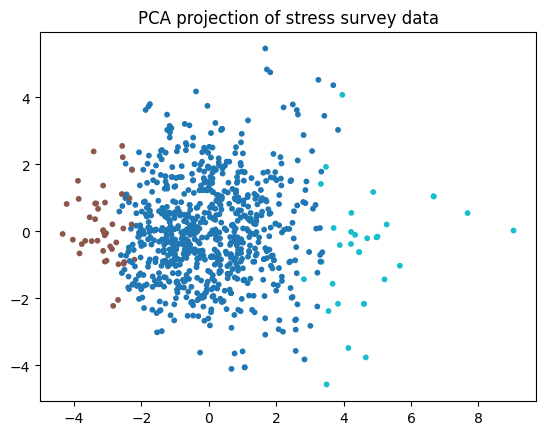

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


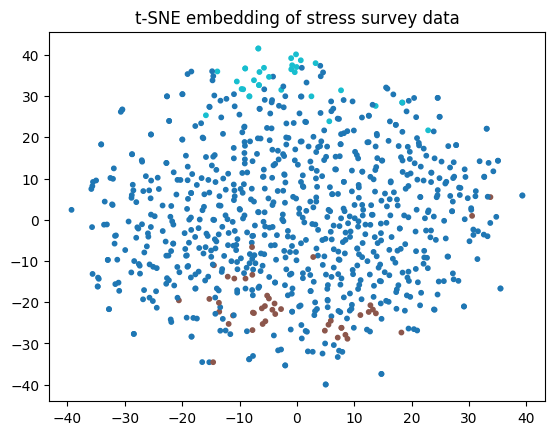

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=pd.factorize(y)[0], cmap='tab10', s=10)
plt.title("PCA projection of stress survey data")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=pd.factorize(y)[0], cmap='tab10', s=10)
plt.title("t-SNE embedding of stress survey data")
plt.show()